# Home Credit Default Risk Analysis 
*Dimitar Vlassarev 2018*

**Plan for analysis:**
1. Pre-process data and split into X, y and Train/Test
2. Encode categorical variables
3. Impute missing values
4. Standardize features
5. PCA and pick number of components
6. Fit a reference Random Forest Model
7. Add SMOTE due to imbalance and refit Random Forest Model
8. Optional - hyper-param tuning for Random Forest Model
9. Gluon + MXNet model compare to Random Forest Model
10. Try out SMOTE or similar vs threshold adjustments and full minority injections in SGD
11. Optimize Random Forest Model
12. Explore other datasets and when not one-to-one variable select on aggregates and add columns to original set. Repeat 1-10 (possibly skipping non ANN steps)
13. Additional feature engineering and ANN tuning (architecture, activations, initialization)

## Load Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Class
Carries some similarities to pipeline implementation but allows for more flexibility.

In [15]:
class dataset(object):
    """A dataset class that will take the data and do pre-processing and in some cases
    modeling of the data. Instance variable data will hold a Pandas dataframe.
    
        @param path (str): String to the csv file (can be zipped) to load.
        @param exclude (list): Columns that should not be normalized or imputed.
        @param target (str): Column that is the target variable."""
    
    def __init__(self, path, exclude, target):
        """Loads data."""
        self.data = pd.read_csv(path)
        self.exclude = exclude
        self.target = target
        self.feature_columns = [col for col in self.data.columns 
                                if col not in (exclude + [target])]
    
    def _clean_col_name(self, name):
        """Cleans column names from special characters and whitespaces.
            @param name (str): Input name.
            @return name (str): Cleaned up name."""

        name = name.upper()
        for c in ", /:":
            name = name.replace(c, "_")
        return(name)
    
    def describe_cardinality(self):
        """Prints the number of levels in each categorical column."""
        categorical_columns = self.data[self.feature_columns].select_dtypes([np.object]).columns
        for col_name in categorical_columns:
            col_data = self.data[col_name]
            print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

    def split_X_y(self):
        """Splits data columns into feature and target sets.
            @return (X, y) (tuple): Features and label."""
        X = self.data[self.feature_columns]
        y = self.data[self.target]
        return(X, y)
    
    def onehot(self, data):
        """Inplace, onehot encodes all the columns in the dataset.
            @param data (pandas.DataFrame): Data to encode.
            @return (data, data.columns): Cargorical variables encoded."""
        data = data.copy()
        categorical_columns = data.select_dtypes([np.object]).columns
        for col_name in categorical_columns:
            dummy_cols = pd.get_dummies(data[col_name])
            dummy_cols.columns = ["{}_{}".format(col_name, self._clean_col_name(dummy_name)) 
                                  for dummy_name in dummy_cols]
            data = data.merge(
                dummy_cols,
                left_index=True,
                right_index=True)
            data = data.drop(col_name, axis=1)
        return(data, data.columns)
    
    def impute(self, data, mode="fit_transform"):
        """Inplace, impute all columns with averages.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @param mode (str): Specifies whether to fit, fit_transform or transform.
            @return data (pandas.DataFrame): Imputed data."""
        if "fit" in mode:
            self.imp = Imputer().fit(data)
        if "transform" in mode:
            return(pd.DataFrame(self.imp.transform(data), columns=data.columns))
        
    def standardize(self, data, mode="fit_transform"):
        """Inplace, mean and std normalizes all columns except exclude.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @param mode (str): Specifies whether to fit, fit_transform or transform.
            @return data (pandas.DataFrame): Standardized data."""
        if "fit" in mode:
            self.standard = StandardScaler().fit(data)
        if "transform" in mode:
            return(pd.DataFrame(self.standard.transform(data), columns=data.columns))
    
    def pca(self, data, n_components=None, plot=True, mode="fit_transform"):
        """Runs PCA on the data and explores the number of components needed.
            @param n_components (int): Number of max components to consider.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @param mode (str): Specifies whether to fit, fit_transform or transform.
            @return data (pandas.DataFrame): PCA transformed data."""
        df = data.copy()
        if "fit" in mode:
            if not n_components:
                n_components = df.shape[1]
            pca = PCA(n_components=n_components)
            self.pca_model = pca.fit(df)

            if plot:
                matplotlib.rcParams.update({'font.size': 16})
                plt.figure(figsize=(16, 9))
                plt.plot(range(1, n_components + 1), 
                         np.cumsum(pca.explained_variance_ratio_),
                        linewidth=3, alpha=0.7, color="r")
                plt.title("Variance Explained vs Number of Components")
                plt.xlabel("Number of principal components")
                plt.ylabel("Relative variance explained")
                plt.ylim((0, 1.01))
                plt.grid(alpha=0.5)
        if "transform" in mode:
            return(self.pca_model.transform(df))
        
    def split_train_test(self, X, y, test_size=0.2):
        """Splits feature and target data sets into test and train.
            @param X (pandas.DataFrame): X data
            @param y (series): y data
            @param test_size (float): fraction of data for test
            @return X_train, X_test, y_train, y_test (tuple): split data"""
        return(train_test_split(X, y, test_size=test_size, random_state=757))
    
    def minority_oversample(self, X, y):
        """Oversamples minority class to balance it.
            @param X (pandas.DataFrame): X data
            @param y (series): y data
            @return X, y where X and y have been balanced (with minority oversampling)"""
        self.sm = SMOTE(random_state=42)
        return(self.sm.fit_sample(X, y))

## Pre-Processing Data

NAME_CONTRACT_TYPE           has  2 levels.
CODE_GENDER                  has  3 levels.
FLAG_OWN_CAR                 has  2 levels.
FLAG_OWN_REALTY              has  2 levels.
NAME_TYPE_SUITE              has  8 levels.
NAME_INCOME_TYPE             has  8 levels.
NAME_EDUCATION_TYPE          has  5 levels.
NAME_FAMILY_STATUS           has  6 levels.
NAME_HOUSING_TYPE            has  6 levels.
OCCUPATION_TYPE              has 19 levels.
WEEKDAY_APPR_PROCESS_START   has  7 levels.
ORGANIZATION_TYPE            has 58 levels.
FONDKAPREMONT_MODE           has  5 levels.
HOUSETYPE_MODE               has  4 levels.
WALLSMATERIAL_MODE           has  8 levels.
EMERGENCYSTATE_MODE          has  3 levels.


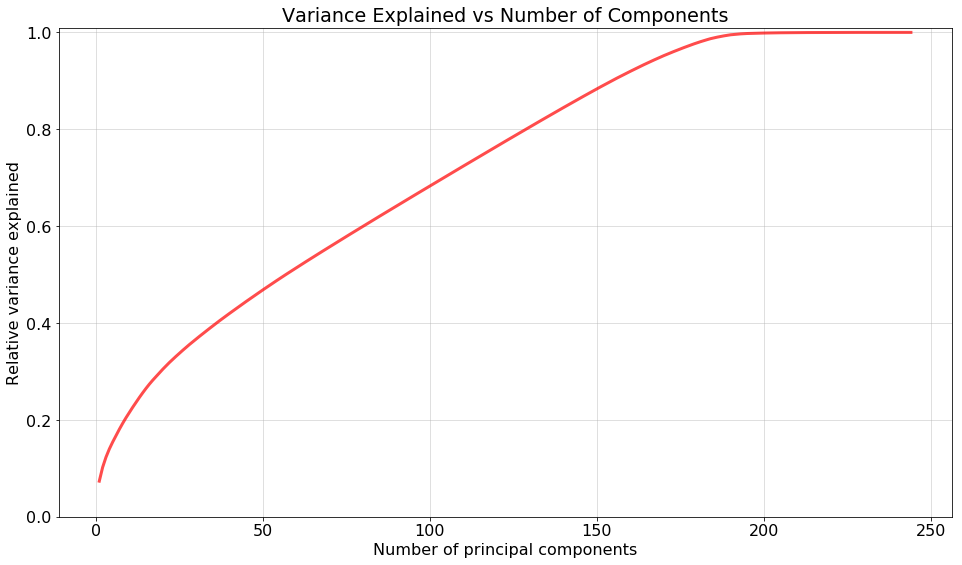

In [16]:
# Pre-processing
app = dataset(r"data/application_train.csv.zip", ["SK_ID_CURR"], "TARGET")
app.describe_cardinality()
app.X, app.y = app.split_X_y()
app.X, app.feature_columns = app.onehot(app.X)
app.X_train, app.X_test, app.y_train, app.y_test = app.split_train_test(app.X, app.y)

app.X_train = app.impute(app.X_train)
app.X_train = app.standardize(app.X_train)
app.pca(app.X_train, mode="fit")
app.X_train = app.pca(app.X_train, mode="fit_transform", n_components=170, plot=False)

app.X_test = app.impute(app.X_test, mode="transform")
app.X_test = app.standardize(app.X_test, mode="transform")
app.X_test = app.pca(app.X_test, mode="transform")

## Random Forest First Look

In [28]:
rfc = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=50)
rfc.fit(app.X_train, app.y_train)

rfc_mo = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=50)
rfc_mo.fit(*app.minority_oversample(app.X_train, app.y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Random Forest Classifier
Train Accuracy: 0.919
Test Accuracy:  0.920
Confusion Matrix for 0.1 threhold.
[[49014  7560]
 [ 3320  1609]]
Area Under the Curve
0.6755020273280232
Random Forest Classifier
Train Accuracy: 0.659
Test Accuracy:  0.653
Confusion Matrix for 0.1 threhold.
[[    0 56574]
 [    0  4929]]
Area Under the Curve
0.660769634720336


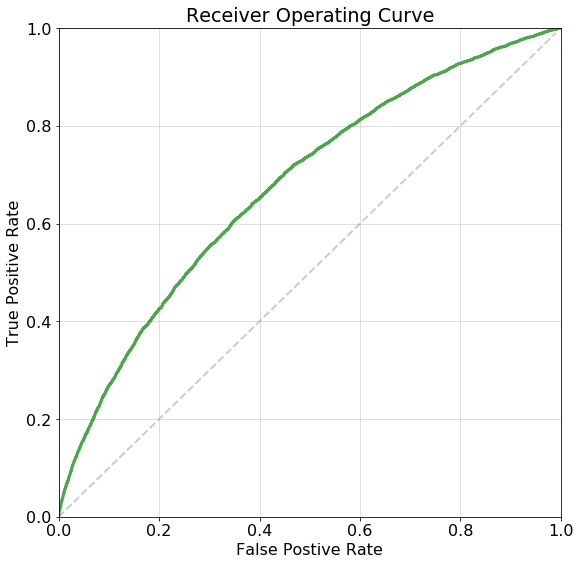

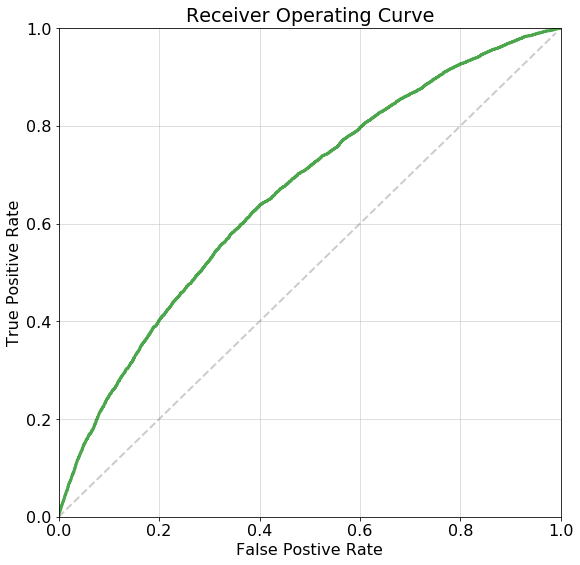

In [33]:
def eval_rfc(rfc):
    """ Evaluates a provided fitted Random Forest Classifier
        @param rfc: Random Forest Classifier"""
    # Basic Accuracy and Confussion Matrix
    print("Random Forest Classifier\nTrain Accuracy: {:.3f}\nTest Accuracy:  {:.3f}".format(
    rfc.score(app.X_train, app.y_train), rfc.score(app.X_test, app.y_test)))
    y_test_score = [p2 for p1, p2 in rfc.predict_proba(app.X_test)]
    fpr, tpr, thresholds = roc_curve(app.y_test, y_test_score)
    thresh = 0.1
    print("Confusion Matrix for {} threhold.".format(thresh))
    print(confusion_matrix(app.y_test, (np.array([p2 for p1, p2 in rfc.predict_proba(app.X_test)]) > thresh).astype("int")))
    matplotlib.rcParams.update({'font.size': 16})

    # AUC
    print("Area Under the Curve")
    print(roc_auc_score(app.y_test, y_test_score))

    # Plot ROC
    plt.figure(figsize=(9, 9))
    plt.plot(fpr, tpr, linewidth=3, alpha=0.7, color="g")
    plt.plot(np.array(range(100)) / 100.0, np.array(range(100)) / 100.0, 
             linestyle='--', linewidth=2, alpha=0.4, color="gray")
    plt.title("Receiver Operating Curve")
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Positive Rate")
    plt.ylim((0, 1.001))
    plt.xlim((0, 1.000))
    plt.grid(alpha=0.5)

eval_rfc(rfc)
eval_rfc(rfc_mo)

## Load Data

In [ ]:
# Load data into dataframes
application_train     = pd.read_csv(r"data/application_train.csv.zip")
# application_test      = pd.read_csv(r"data/application_test.csv.zip")
# bureau                = pd.read_csv(r"data/bureau.csv.zip")
# bureau_balance        = pd.read_csv(r"data/bureau_balance.csv.zip")
# credit_card_balance   = pd.read_csv(r"data/credit_card_balance.csv.zip")
# installments_payments = pd.read_csv(r"data/installments_payments.csv.zip")
# pos_cash_balance      = pd.read_csv(r"data/POS_CASH_balance.csv.zip")
# previous_application  = pd.read_csv(r"data/previous_application.csv.zip")
columns_description   = pd.read_csv(r"data/HomeCredit_columns_description.csv", encoding='cp1252')

## Display Column descriptions

In [ ]:
# Column descriptions
pd.options.display.max_rows = 500
display(columns_description[["Table", "Row", "Description", "Special"]])
pd.reset_option("max_rows")

In [ ]:
# Pick out string columns
cardinal_columns = application_train.select_dtypes([np.object]).columns
for col_name in cardinal_columns:
    col_data = application_train[col_name]
    print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

# One-hot encode all the cardinal columns
def clean_col_name(name):
    """
        Cleans column names from special characters and whitespaces.
        @param name (str): Input name
        @return name (str): Cleaned up name
    """
    
    name = name.upper()
    name = name.replace(",", "_")
    name = name.replace(" ", "_")
    name = name.replace("/", "_")
    name = name.replace(":", "_")
    return(name)

for col_name in cardinal_columns:
    dummy_cols = pd.get_dummies(application_train[col_name])
    dummy_cols.columns = ["{}_{}".format(col_name, clean_col_name(dummy_name)) for dummy_name in dummy_cols]
              
    application_train = application_train.merge(
        dummy_cols,
        left_index=True,
        right_index=True)
    application_train = application_train.drop(col_name, axis=1)

In [ ]:
application_train.describe()

In [ ]:
for col in application_train.columns:
    print(col)

In [ ]:
# Target data appears to be all present and only contain 0 and 1 values
y = application_train["TARGET"].copy()

In [ ]:
application_train["EXT_SOURCE_1"].describe()

In [ ]:
application_train[["NAME_CONTRACT_TYPE"]].merge(
    pd.get_dummies(application_train["NAME_CONTRACT_TYPE"]),
    left_index=True,
    right_index=True)

In [ ]:
X = application_train[["CNT_CHILDREN", 
                  "AMT_INCOME_TOTAL",
                  "AMT_CREDIT",
                  "AMT_ANNUITY",
                  "AMT_GOODS_PRICE",
                  "DAYS_BIRTH",
                  "DAYS_EMPLOYED"]].copy()

In [ ]:
mask = X.isna().apply(lambda row: not any(row), axis=1)

In [ ]:
X = X[mask].values
y = y[mask].values

In [ ]:
pca = PCA(n_components=2)
pca_model = pca.fit(X)